# 1. Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
path = 'test_images/test2.jpg'
test_image = plt.imread(path)

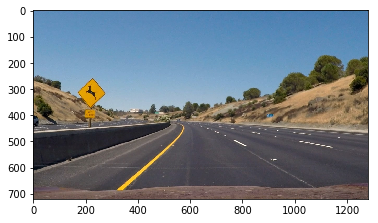

In [4]:
plt.imshow(test_image);

# 2. Camera Callibration

In [5]:
def calibrate_camera(image_folder, chess_size = (6, 9)):
    """
     image_folder: (str) path of image folder
     chess_size: (Tuple) Corners in chess Images
     
     returns tuple(list(object_points, image_points))
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) 
    # here objets points are like (x, y, z), z is always zero as for channel=1(2D image)
    obj_p = np.zeros((chess_size[0]*chess_size[1], 3), np.float32)
    obj_p[:, :2] = np.mgrid[0:chess_size[1], 0:chess_size[0]].T.reshape(-1, 2) # since x in image is columns and y is row
    
    # Lists to store object points and image points from all the images
    object_points = [] # 3d points in real world space
    image_points = [] # 2d points in image plane
    
    images = glob.glob(f'{image_folder}/cal*.jpg')
    # Step through the list and search for chessboard corners
    for idx, image in enumerate(images):
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chess_size[1], chess_size[0]))
        
        # IF found, add object points, image points
        if ret == True:
            object_points.append(obj_p)
            image_points.append(corners)
    
    return object_points, image_points

In [6]:
# object poinds, image points for undistorting the image
obj_points, img_points = calibrate_camera('camera_cal')

In [7]:
def create_undistorted_image(img, obj_points=[], img_points=[]):
    """
    returns: undistorted image
    """
    #img = cv2.imread(img)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given objects and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undisorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undisorted_image

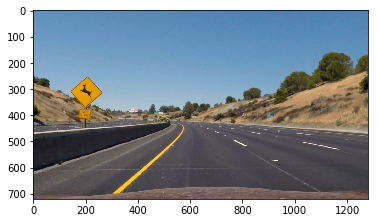

In [9]:
undistorted_image = create_undistorted_image(test_image, obj_points, img_points)
plt.imshow(undistorted_image)
plt.imsave('test_images/undistorted_image.jpg', undistorted_image)

# 3. Perspective Transform

In [10]:
def warp(img, inv=False):
    """
    img: image either gray scale or 3 channel image
    inv(inverse): `False` returns warped and
                   `True` return unwarped
    """
    img_size = (img.shape[1], img.shape[0])
    
    x_size, y_size = img_size
    

    src = np.float32([
        [384, y_size - 55],
        [896, y_size - 55],
        [699, 477],
        [581, 477]
    ])

    dst = np.float32([
        [384, y_size],
        [896, y_size],
        [896, 0],
        [384, 0]
    ])
    
    if inv:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [11]:
warped = warp(undistorted_image)
plt.imsave('test_images/warped.jpg', warped)

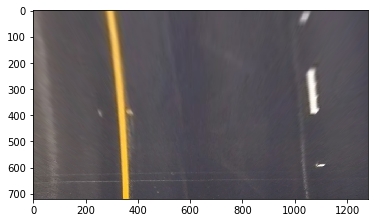

In [12]:
plt.imshow(warped);

# 4. Image Color Space Manipulation

In [13]:
def pipeline(warped):
    """
    Returns a binary image
    """
    R = warped[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    R = clahe.apply(R)
    
    thresh = (200, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > thresh[0])&(R <= thresh[1])] = 1
   
    return r_binary

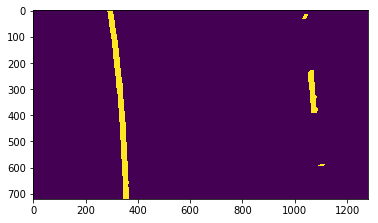

In [18]:
binary_warped = pipeline(warped)
plt.imshow(binary_warped);

# 5. Region of Interest

In [15]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [16]:
coordinte_mask = [np.array([[250, 720], [1150, 720], [1150, 0], [250, 0]])]
required_region = region_of_interest(binary_warped, coordinte_mask)

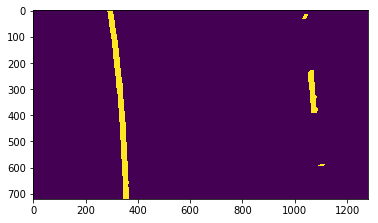

In [17]:
plt.imshow(required_region);

# 6. Class For Frame and Line Tracking

In [19]:
class Frame:
    """
    Class for further Improvement in project
    """
    def __init__(self):
        self.fit = None
        self.frame_count = 0

In [20]:
class Line:
    def __init__(self):
        #self.fit = None
        #self.frame_count = 0
        
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        self.all_coeff = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.pos_of_vehicle = None 
        #difference in fit coefficients between last and new fits
        self.diffs = None
        #x values for detected line pixels
        self.allx = []
        #y values for detected line pixels
        self.ally = []
        # all coefficients till `n` frames
        self.all_coeffiecient = []
        # number of frames 
        self.n = 5
        # standard deviation (percentage range between coefficient)
        self.std = 0.3
    
    def best_x(self, coeffiecient):
        if self.all_coeff:
            
            self.allx.append(coeffiecient)
            if len(self.allx)> self.n: # remove coeffiecient from bottom based on `n` we set in __init__
                del self.allx[0]
           # appending mean as current coefficient is far from standard deviation
                
            avg = np.average(np.array(self.allx), axis=0) # again computing mean as included current coefficient
            return avg
            
        else:
            self.allx.append(coeffiecient)
            return coeffiecient
    
    def valid_coeffiecient(self, coeffiecient):
        """
        Check the validation of coeffiecient based on mean and standard deviation and modify
        based on the requirement
        """
        temp = np.array(self.all_coeffiecient)
        
        if self.all_coeffiecient: #all frames except first frame
            
            mean = np.mean(np.array(self.all_coeffiecient), axis=0) 
            std = np.abs(self.std*mean)
            
            test_coeff =((mean - std)<=coeffiecient) & (coeffiecient <= (mean + std)) # check if coeffiecients lie in range
            flag = np.any(test_coeff) # flag to check if any of coeffiecient is nearby
            
            if flag: # if coeffiecients are in range add them to `all_coeffiecient` list
                self.all_coeffiecient.append(coeffiecient)
                if len(self.all_coeffiecient)> self.n: # remove coeffiecient from bottom based on `n` we set in __init__
                    del self.all_coeffiecient[0]
            else: # else append mean
                self.all_coeffiecient.append(mean) # appending mean as current coefficient is far from standard deviation
                
            mean = np.mean(np.array(self.all_coeffiecient), axis=0) # again computing mean as included current coefficient
            return mean
        else: # for first frame
            self.all_coeffiecient.append(coeffiecient)
            return coeffiecient
    
    
    def measure_curvature(self, fitx, ploty):
        """
        measures curvature of line in metres
        """
    
        ykm_per_pix = 30/(720*1000) # meters per pixel in y dimension
        xkm_per_pix = 3.7/(700*1000) # meters per pixel in x dimension
    
    
        fit_cr = np.polyfit(ploty*ykm_per_pix, fitx*xkm_per_pix, 2)
    
        y_eval = np.max(ploty)
    
        radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ykm_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
        return radius_of_curvature
    
    def position_from_lane(self, leftx, rightx, ploty):
        """
        tracks position of vehicle
        """
        xm_per_pixel = 3.7/700
    
        left_lane_position = leftx[-1]
        right_lane_position = rightx[-1]
        calc_centre = (right_lane_position - left_lane_position)/2 + left_lane_position
        actual_centre = 1280/2
        vehicle_position = (actual_centre - calc_centre)*xm_per_pixel
        
        return vehicle_position

# 7. Tracking Lanes

# 7.1. Histogram of Image Based on Pixel Intensity

In [21]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# 7. 2 For Detecting Lanes For First Time

In [22]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

# 7.3. For Detecting Lanes and Processing

In [23]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_line.best_fit = left_line.valid_coeffiecient(left_fit)
        left_fit = left_line.best_fit
    except TypeError:
        #left_line.best_fit = left_line.valid_coeffiecient(left_line.best_fit)
        left_fit = left_line.best_fit

    try:
        right_fit = np.polyfit(righty, rightx, 2)
        right_line.best_fit = right_line.valid_coeffiecient(right_fit)
        right_fit = right_line.best_fit
    except TypeError:
        #right_line.best_fit = right_line.valid_coeffiecient(right_line.best_fit)
        right_fit = right_line.best_fit

        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    ############# test code ################
    if frame.frame_count == 0:
        frame.fit = fit_polynomial(binary_warped)
    
    left_fit, right_fit = frame.fit
    frame.frame_count += 1
    ##############################################
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
 
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
  
    #radius of curvature of both lines
    left_line.radius_of_curvature = left_line.measure_curvature(left_fitx, ploty)
    right_line.radius_of_curvature = right_line.measure_curvature(right_fitx, ploty)
    
    # Vehicle postion 
    left_line.pos_of_vehicle = left_line.position_from_lane(leftx, rightx, ploty)
    
    if left_line.radius_of_curvature > 0.5: 
        left_line.bestx = left_line.best_x(left_fitx)

    else:
        left_fitx = left_line.bestx
    
    if right_line.radius_of_curvature > 0.5:
        right_line.bestx = right_line.best_x(right_fitx)
    
    else:
        right_fitx = right_line.bestx
    
    return left_fitx, right_fitx, ploty

# 8. Merging Images

In [24]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# 9. Filling green color between Lanes, adding radius of curvature and postion of vehicle on Image

In [25]:
def draw(undist_image, warped_out, left_fitx, right_fitx, ploty):
    """
    undist_image: image without any modification.
    warped_out: out from search_around_poly function
    left_fitx: 
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_out).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warped_inv = warp(color_warp, inv=True)
    
    weighted_out = weighted_img(warped_inv, undist_image)
    cv2.putText(weighted_out, f"radius of curvature: {left_line.radius_of_curvature:.2f}km", (40, 70), cv2.FONT_HERSHEY_DUPLEX, 1.5,  (200,255,155), 2, cv2.LINE_AA)
    
    if left_line.pos_of_vehicle < 0:
        vehicle_position = 'left'
    else:
        vehicle_position = 'right'
        
    cv2.putText(weighted_out, f"Vehicle is {left_line.pos_of_vehicle:.2f}m {vehicle_position} of center", (40, 120), cv2.FONT_HERSHEY_DUPLEX, 1.5,  (200,255,155), 2, cv2.LINE_AA)
    
    return weighted_out

# 10. Function for processing and tracking of lane in image

In [26]:
def process_image(image):
    
    undistorted_image = create_undistorted_image(image, obj_points, img_points)

    y_size, x_size, _ = image.shape
    
    warped = warp(image)
    coordinte_mask = [np.array([[250, y_size], [1150, y_size], [1150, 0], [250, 0]])]
    warped = region_of_interest(warped, coordinte_mask)
    binary_warped = pipeline(warped)
    leftx, rightx, ploty = search_around_poly(binary_warped)
    weighted_out = draw(image, binary_warped, leftx, rightx, ploty)
    
    return weighted_out

In [85]:
frame=Frame()
left_line, right_line = Line(), Line()
line =  left_line, right_line
test_image_output = process_image(test_image)

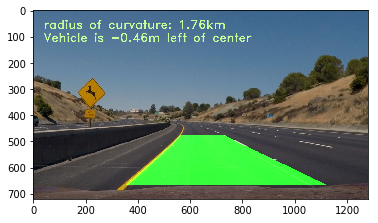

In [86]:
plt.imshow(test_image_output);
plt.imsave('test_images/test_image_output', test_image_output)

# 11. Tracking Lanes in video

# 11.1. Project Video Lane Tracking

In [27]:
frame=Frame()
left_line, right_line = Line(), Line()
line =  left_line, right_line

project_video_output = 'project_video_output.mp4'

clip = VideoFileClip('project_video.mp4')#.subclip(49, 50)
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [11:51<00:00,  1.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 44s, sys: 2.85 s, total: 9min 47s
Wall time: 11min 54s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

# 11.2 Challenge Video Output

In [37]:
frame=Frame() 
left_line, right_line = Line(), Line()
line =  left_line, right_line

challenge_video_output = 'challenge_video_output.mp4'

clip = VideoFileClip('challenge_video.mp4')
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 32%|███▏      | 155/485 [01:25<03:06,  1.77it/s]


 64%|██████▎   | 309/485 [02:52<01:38,  1.79it/s]


 95%|█████████▌| 463/485 [04:18<00:12,  1.77it/s]


100%|██████████| 485/485 [04:30<00:00,  1.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 3min 43s, sys: 936 ms, total: 3min 44s
Wall time: 4min 33s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))